In [ ]:
#| default_exp t2s_up
%load_ext autoreload
%autoreload 2

In [ ]:
#| exporti
import math
import numpy as np
import torch
import torch.nn as nn
from torch.profiler import record_function

from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr
from fastprogress import progress_bar

In [ ]:
#| exporti
from pathlib import Path
import pylab as plt
import pandas as pd

In [ ]:
#| exporti
import whisper
from whisperspeech.train import *
from whisperspeech.modules import *

/opt/conda/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


In [ ]:
datadir = Path('/root/workspace/stoks-txts/')

# Dataset

## Load the data

In [ ]:
data = pd.DataFrame(dict(stoks=[str(x) for x in Path(datadir).rglob('*.stoks')]))

In [ ]:
data['text'] = data['stoks'].apply(lambda x: Path(x).with_suffix('.txt').read_text())

In [ ]:
data

,stoks,text
0,/root/workspace/stoks-txts/medium/yearamongstt...,The man in question was summoned and interrog...
1,/root/workspace/stoks-txts/medium/eldorado_19_...,This is too intricate a matter to be dealt wi...
2,/root/workspace/stoks-txts/medium/leviathan_29...,"a neighboring nation, dispose of men to alter..."
3,/root/workspace/stoks-txts/medium/modernghosts...,Such an outline would not give the slightest ...
4,/root/workspace/stoks-txts/medium/mike_07_wode...,"was not, therefore, a prospect that appealed ..."
...,...,...
140654,/root/workspace/stoks-txts/small/canterburytal...,"And eek Tertullian, Chrysippus, Trotola, and ..."
140655,/root/workspace/stoks-txts/small/manofproperty...,"Bessinie was waiting for him at the door, and..."
140656,/root/workspace/stoks-txts/small/toysofpeace_1...,"crest of the hill, and wandered far down the ..."
140657,/root/workspace/stoks-txts/small/tristramshand...,"""'They are running at the ring of pleasure,' ..."


In [ ]:
print(f"{len(data) * 26 / 3600} hours of (auto)transcribed speech") # average sample length is 26s

1015.8705555555556 hours of (auto)transcribed speech


In [ ]:
#| exporti
def load_data(path:Path):
    data = pd.DataFrame(dict(stoks=[str(x) for x in Path(path).rglob('*.stoks')]))
    data['stoks_len'] = data['stoks'].map(lambda x: torch.load(x).shape[1]/50)
    data['text'] = data['stoks'].apply(lambda x: Path(x).with_suffix('.txt').read_text())
    data['ttoks_len'] = data['text'].map(lambda x: len(tokenizer.encode(x)))
    return data

In [ ]:
data = pd.read_feather('stoks-txts.feather')

In [ ]:
import re

In [ ]:
data['txt_tiny_wc'] = data['txt_tiny'].map(lambda x: len(re.findall(r'\w+', x)))

In [ ]:
data['txt_large_wc'] = data['txt_large'].map(lambda x: len(re.findall(r'\w+', x)))

In [ ]:
data['wc_err'] = data['txt_large_wc'] - data['txt_tiny_wc']

In [ ]:
data.sort_values('wc_err')

,fname,j,tstart,tend,stoks,txt_tiny,txt_large,txt_tiny_wc,txt_large_wc,wc_err
535268,medium/123/hymns_of_the_christian_church_0805_...,4,92.652188,118.454063,"[264, 659, 659, 659, 659, 527, 438, 189, 928, ...","Get in normal, lie down in sin. Watch by the ...","Let him no more lie down in sin, Watched by t...",222,34,-188
105251,medium/543/enchanted_island_yew_librivox_64kb_...,53,1283.875313,1306.842187,"[233, 1016, 1016, 1016, 1016, 834, 834, 984, 1...","To think, Sout will take him miserably, only ...","To think, sobbed Woolteke miserably, only to ...",215,30,-185
525192,medium/298/spy_cooper_librivox_64kb_mp3/spy_11...,1,26.063438,47.005313,"[155, 650, 244, 862, 402, 666, 666, 666, 666, ...",O wo wo wo wo wo wo wo wo wo wo wo wo wo wo w...,"O woe! O woeful, woeful, woeful day! Most lam...",224,44,-180
667331,medium/4881/shirley_1006_librivox_64kb_mp3/shi...,48,1228.508438,1247.104688,"[740, 659, 659, 659, 985, 579, 187, 187, 187, ...",Monpero Yaf and Kaur is the one who is the on...,Mon beau voyage encore est si loin de sa fin....,220,41,-179
74470,small/112/o_canada_librivox_64kb_mp3/o_canada_...,1,17.305312,46.988438,"[511, 659, 659, 295, 295, 122, 268, 268, 268, ...",I don't want to say that I don't want to say ...,"Au Canada, terre de nos aïeux, ton front est ...",224,55,-169
...,...,...,...,...,...,...,...,...,...,...
206312,medium/688/fortieth_door_librivox_64kb_mp3/for...,19,458.232188,475.832813,"[669, 659, 659, 690, 80, 269, 269, 269, 269, 2...","came Amy's shaken voice, oh, you are safe."" H...","She was a young girl, and she was a young gir...",56,192,136
207282,medium/688/fortieth_door_librivox_64kb_mp3/for...,51,1168.382812,1191.332813,"[742, 659, 244, 956, 158, 660, 660, 660, 731, ...","You were going to leave me? Strangely, her ey...","I had not seen him for a long time, and I had...",67,204,137
206963,medium/688/fortieth_door_librivox_64kb_mp3/for...,2,49.823438,69.989063,"[1016, 1016, 1016, 280, 2, 466, 311, 311, 311,...",before the Sudanese marshalled them toward th...,"There was no one in the house, and no one in ...",58,198,140
207141,medium/688/fortieth_door_librivox_64kb_mp3/for...,34,730.172813,750.608438,"[980, 47, 47, 47, 47, 978, 978, 484, 317, 484,...",were being relieved of their huge loads by na...,"The young man, who had not yet come to his se...",58,200,142


In [ ]:
x = data.loc[206312]
print(x['txt_tiny'])
print()
print(x['txt_large'])
print(x['tend'] - x['tstart'])

 came Amy's shaken voice, oh, you are safe." He felt her trembling in his clasp and he swept her close to him. For one breathless instant they clung together in a sharp, passionate gladness which blurred every sense of dread or danger. They were safe, they were together, and for the moment it was enough.

 She was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young girl, and she was a young 

In [ ]:
data_clean = data[data['wc_err'].abs() < 5]

In [ ]:
data_clean

,fname,j,tstart,tend,stoks,txt_tiny,txt_large,txt_tiny_wc,txt_large_wc,wc_err
1,small/2769/murder_gunroom_0902_librivox_64kb_m...,1,16.697813,40.643438,"[4, 1016, 1016, 68, 451, 451, 451, 967, 967, 9...",Murder in the Gunroom by each being Piper. In...,Murder in the Gun Room by H. Beam Piper Intro...,63,65,2
2,small/2769/murder_gunroom_0902_librivox_64kb_m...,2,40.643438,62.884688,"[659, 1016, 280, 926, 425, 425, 425, 425, 425,...",enough at any rate to engage Colonel Jefferso...,Enough at any rate to engage Colonel Jefferso...,67,66,-1
3,small/2769/murder_gunroom_0902_librivox_64kb_m...,3,63.711563,91.032188,"[294, 659, 659, 244, 244, 956, 956, 765, 765, ...",Here's a mystery told against the fascinating...,Here is a mystery told against the fascinatin...,78,78,0
5,small/2769/murder_gunroom_0902_librivox_64kb_m...,1,27.784688,54.784688,"[994, 659, 1016, 1016, 704, 417, 42, 573, 573,...","Why, hello Jeff! He greeted the detective, gr...","Why, hello, Jeff!"" he greeted the detective, ...",84,84,0
6,small/2769/murder_gunroom_0902_librivox_64kb_m...,2,55.206563,64.740938,"[984, 650, 659, 862, 446, 559, 559, 559, 559, ...",I understand that you and some others are for...,I understand that you and some others are for...,25,25,0
...,...,...,...,...,...,...,...,...,...,...
783616,medium/3470/worm_ouroboros_jm_librivox_64kb_mp...,20,566.451563,588.372188,"[660, 1016, 1016, 950, 278, 811, 811, 811, 811...","said ever fresh dishes before the feasters, a...","set ever fresh dishes before the feasters, an...",79,79,0
783617,medium/3470/worm_ouroboros_jm_librivox_64kb_mp...,21,589.283438,618.291563,"[732, 1016, 1016, 976, 216, 731, 731, 731, 731...","Great was the clatter of cups, and great the ...","Great was the clatter of cups, and great the ...",99,96,-3
783618,medium/3470/worm_ouroboros_jm_librivox_64kb_mp...,22,618.797813,647.130938,"[429, 650, 757, 611, 447, 447, 99, 99, 99, 99,...","but this by stealth only, and out of our shot...","put this by stealth only, and out of eyeshot ...",92,93,1
783619,medium/3470/worm_ouroboros_jm_librivox_64kb_mp...,23,648.160313,676.932188,"[135, 659, 244, 650, 522, 522, 522, 522, 522, ...","I scarce, can blame him, as a girl, to some m...","I scarce can blame him,"" answered Gros. ""'Tis...",100,97,-3


## Prepare the datasets

In [ ]:
tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)

In [ ]:
ttoks_len = data_clean['txt_large'].map(lambda x: len(tokenizer.encode(x)))

In [ ]:
ttoks_len.max(), ttoks_len.min()

(224, 1)

<Axes: >

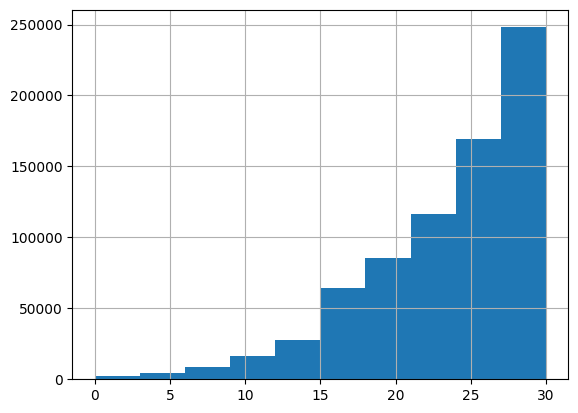

In [ ]:
(data_clean['tend'] - data_clean['tstart']).hist()

In [ ]:
import numpy as np

In [ ]:
#| exporti
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.stoks_len = 1500
        self.ttoks_len = 250
    
    def __len__(self):
        return len(self.data)
            
    def __repr__(self):
        return f"<Dataset: {len(self)} samples>"
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        t = row['tend'] - row['tstart']
        Stoks = row['stoks'][:int(t/30*1500+.5)]
        Ttoks = self.tokenizer.encode(row['txt_large'])
        return F.pad(torch.tensor(Ttoks), (0, self.ttoks_len - len(Ttoks)), value=self.tokenizer.eot).to(torch.long), \
               F.pad(torch.tensor(Stoks), (0, self.stoks_len - len(Stoks)), value=1024).to(torch.long)

In [ ]:
val_data, train_data = data[:300], data[300:]
val_ds = SADataset(val_data, tokenizer)
val_ds

<Dataset: 300 samples>

In [ ]:
train_ds = SADataset(train_data, tokenizer)
train_ds

<Dataset: 783321 samples>

In [ ]:
#| export
import re

def load_datasets(path:Path):
    tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)
    data = pd.read_feather(path)
    data['txt_tiny_wc'] = data['txt_tiny'].map(lambda x: len(re.findall(r'\w+', x)))
    data['txt_large_wc'] = data['txt_large'].map(lambda x: len(re.findall(r'\w+', x)))
    data['wc_err'] = data['txt_large_wc'] - data['txt_tiny_wc']
    data_clean = data[data['wc_err'].abs() < 5]
    
    val_data, train_data = data_clean[:300], data_clean[300:]

    return SADataset(train_data, tokenizer), SADataset(val_data, tokenizer)

In [ ]:
train_ds, val_ds = load_datasets('/root/workspace/whisperspeech-librilight-stoks-txt-small-medium-A.feather')

# Modeling

In [ ]:
#| export
import dataclasses
import random

def rand(start, end):
    return random.random() * (end - start) + start

@dataclasses.dataclass
class Tunables:
    init_std :float = 1
    embeddings_std :float = .01
    embeddings_lr_scale: float = 5
    output_mult :float = .35
    query_mult :float = 1
    encoder_depth_ratio :float = 0.25
        
    lr0 :float = 3e-3
    clip_gradient_norm :float = .2
    weight_decay :float = 1e-5
    warmup_steps :float = 4000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
#             self.init_std = 10**rand(-3,1)
            self.init_std = 10**rand(-1,1)
#             self.embeddings_std = 10**rand(-3,1)
            self.embeddings_std = 10**rand(-3,-.7)
#             self.embeddings_lr_scale = 2**rand(-3,3)
            self.embeddings_lr_scale = rand(2,6) #2**rand(0,3)
#             self.output_mult = 2**rand(-2,3)
            self.output_mult = rand(0.25,0.65)
            self.query_mult = 2**rand(-2,3)
#             self.encoder_depth_ratio = random.choice([0.25,0.5,0.75])
            self.encoder_depth_ratio = 0.25
            
#             self.lr0 = 10**rand(-4,-1.5)
            self.lr0 = rand(1,5)*1e-3
            self.clip_gradient_norm = 10**rand(-3,0)
            self.warmup_steps = 100*(10**rand(1,1.85))

In [ ]:
Tunables(random=True)

Tunables(init_std=0.0481705845688257, embeddings_std=0.2013323306023991, embeddings_lr_scale=0.5327118334373016, output_mult=0.3697151643170823, query_mult=16.669647552030334, encoder_depth_ratio=0.25, lr0=0.0063988496046561835, clip_gradient_norm=0.1, weight_decay=1e-05, warmup_steps=109.12804832635688, random=True)

In [ ]:
#| export
class Encoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
    
        self.embedding = nn.Embedding(codes, width)

        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)

        self.layers = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head,
                                   qk_scale=tunables.query_mult*8/math.sqrt(width/n_head), ffn_mult=ffn_mult) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks):
        xin = self.embedding(Stoks)
        
        assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        xin = (xin + self.positional_embedding).to(xin.dtype)

        return self.ln_post(self.layers(xin))

In [ ]:
#|export
class T2SEmbeddingWithPositional(nn.Module):
    def __init__(self, width, codes, length=None, pos_embs=None):
        super(T2SEmbeddingWithPositional, self).__init__()
        self.embedding = nn.Embedding(codes+1, width)
        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)

    def forward(self, Stoks, xenc_dtype, kv_cache=None):
        offset = next(iter(kv_cache.values())).shape[1] if kv_cache else 0
        
        Sembs = self.embedding(Stoks)
        xin = (Sembs + self.positional_embedding[offset : offset + Stoks.shape[1]]).to(xenc_dtype)
    
        return xin

In [ ]:
#| export
class Decoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
        self.length = length
        self.codes = codes
    
        self.embedding_layer = T2SEmbeddingWithPositional(width, codes, length, pos_embs)
        
        qk_scale = tunables.query_mult*8/math.sqrt(width/n_head)
        self.base_decoder = BaseDecoder(
            depth, width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, cross_attention=True)
        mask = torch.empty(length, length).fill_(-np.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)

    def forward(self, Stoks, xenc, kv_cache=None):
        x = self.embedding_layer(Stoks, xenc.dtype, kv_cache)
    
        x = self.base_decoder(x, xenc, mask=self.mask, kv_cache=kv_cache)
        
        logits = (x @ self.embedding_layer.embedding.weight.to(x.dtype).T).float()
        return logits

In [ ]:
#| export
class TSARTransformer(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, ffn_mult=4, language='en',
                 ttoks_len=200, stoks_len=1500, ttoks_codes=50364, stoks_codes=1024,
                 tunables=Tunables()):
        assert language == 'en', "only english is supported right now"
        super().__init__()
        store_attr("depth,n_head,head_width,ttoks_len,stoks_len,ttoks_codes,stoks_codes,language")

        width = n_head * head_width
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        tformer_args = dict(width=width, n_head=n_head, ffn_mult=ffn_mult, tunables=tunables)
        self.encoder = Encoder(length=ttoks_len, codes=ttoks_codes, depth=encoder_depth, **tformer_args)
        
        self.embedding_layer = T2SEmbeddingWithPositional(width, stoks_codes, stoks_len)
        
        qk_scale = tunables.query_mult*8/math.sqrt(width/n_head)
        self.decoder = BaseDecoder(
            decoder_depth,
            width,
            n_head,
            qk_scale=qk_scale,
            ffn_mult=ffn_mult,
            length=stoks_len,
            cross_attention=True
        )
        
        self.tokenizer = None
        
        self.apply(self.init_transformer)

    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)
        
    def forward(self, Ttoks, Stoks, loss=True, kv_cache=None):
        with record_function("encoder"):
            xenc = self.encoder(Ttoks.to(torch.long))
        with record_function("decoder"):
            x = self.embedding_layer(Stoks, xenc.dtype, kv_cache)
    
            x = self.decoder(x, xenc, kv_cache=kv_cache)

            logits = (x @ self.embedding_layer.embedding.weight.to(x.dtype).T).float()
            logits *= self.tunables.output_mult / (self.width / self.base_width)
        if loss is not None:
            with record_function("loss"):
                loss = F.cross_entropy(logits.reshape(-1,logits.shape[-1]), Stoks.view(-1))
        return logits, loss

    #
    # inference
    #
    @classmethod
    def load_model(cls, repo_id="collabora/whisperspeech", filename="t2s_up.model", local_filename=None):
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        model = cls(**spec['config'], tunables=Tunables(**spec['tunables']))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model

    def load_checkpoint(self, local_filename):
        spec = torch.load(local_filename, map_location='cpu')
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self

    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def ensure_tokenizer(self):
        assert not self.training
        if self.tokenizer is None: self.tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)

    @property
    def device(self):
        return next(self.parameters()).device
    
    @torch.no_grad()
    def generate(self, txt, N=None, T=0.7, top_k=None, kv_cache=None):
        self.ensure_tokenizer()
        N = N or self.stoks_len
        dev = self.device
        ttoks = torch.tensor(self.tokenizer.encode(txt), device=dev)
        ttoks = F.pad(ttoks, (0, self.ttoks_len - len(ttoks)), value=self.tokenizer.eot).unsqueeze(0)
        toks = torch.zeros((1,N), dtype=torch.long, device=dev)
        toks[0,0] = 1024
        for i in progress_bar(range(1, N)):
            toks_ = toks[:, :i]
            
            # send only the last token
            if kv_cache:
                toks_ = toks_[:, -1:]
                
            p, _ = self(ttoks, toks_, loss=None, kv_cache=kv_cache)
            last_p = p[0,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[-1,None]] = -torch.inf
            tok = torch.multinomial((last_p / float(T)).softmax(-1), 1)
            toks[0,i] = tok
            if toks[0,i] == 1024: return toks[0,:i]
        return toks[0]
    
    def install_kv_cache_hooks(self, cache = None):
        """
        The `MultiHeadAttention` module optionally accepts `kv_cache` which stores the key and value
        tensors calculated for the previous positions. This method returns a dictionary that stores
        all caches, and the necessary hooks for the key and value projection modules that save the
        intermediate tensors to be reused during later calculations.

        Returns
        -------
        cache : Dict[nn.Module, torch.Tensor]
            A dictionary object mapping the key/value projection modules to its cache
        hooks : List[RemovableHandle]
            List of PyTorch RemovableHandle objects to stop the hooks to be called
        """
        cache = {**cache} if cache is not None else {}
        hooks = []

        def save_to_cache(module, _, output):
            if module not in cache:
                # save as-is, for the first token or cross attention
                cache[module] = output
            else:
                cache[module] = torch.cat([cache[module], output], dim=1).detach()
            return cache[module]

        def install_hooks(layer: nn.Module):
            if isinstance(layer, MultiHeadAttention):
                hooks.append(layer.key.register_forward_hook(save_to_cache))
                hooks.append(layer.value.register_forward_hook(save_to_cache))

        self.decoder.apply(install_hooks)
        return cache, hooks

In [ ]:
model = make_model('tiny', dataset=train_ds).load_checkpoint('t2s_up-20e-ce1.15.ckpt')

In [ ]:
model.save_model('t2s_up.model')

In [ ]:
#| export
def make_model(size:str, tunables:Tunables=Tunables(), dataset:SADataset=None):
    kwargs = dict(stoks_len = dataset.stoks_len, ttoks_len = dataset.ttoks_len, tunables=tunables)
    if size == 'micro':
        return TSARTransformer(depth=2, n_head=3, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return TSARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return TSARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'small':
        return TSARTransformer(depth=12, n_head=16, **kwargs)

samples,train,val,time
20000,2.93531,3.08976,02:06
40000,2.40885,2.46782,03:47
60000,2.24459,2.34386,05:41
80000,2.25632,2.26977,07:34
100000,2.12768,2.20723,09:35
120000,2.07301,2.15234,11:30
140000,2.11128,2.12581,13:33
140368,2.09136,2.12533,13:36


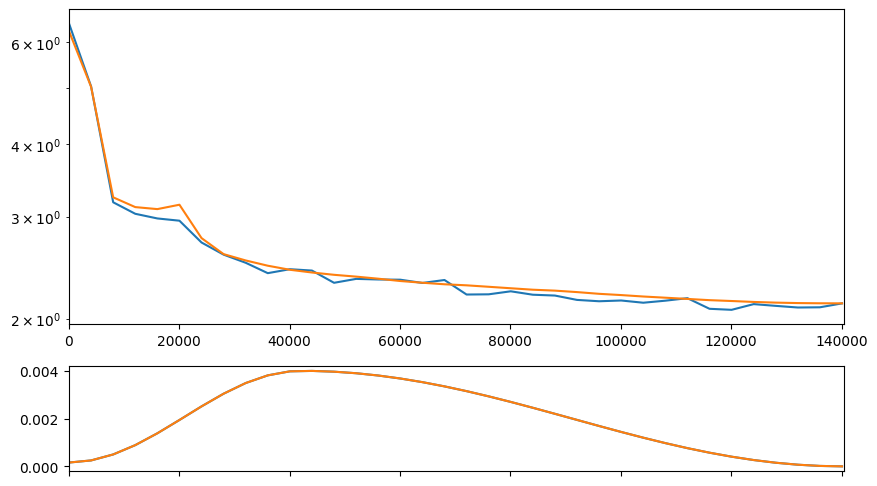

In [ ]:
# make sure it works at all
model = TSARTransformer(depth=3).cuda()
train("/scrach/tsar-checkpoints", model, train_ds, val_ds, half=True, bs=16, lr=4e-3, epochs=1,
      table_row_every_iters=20000, run_valid_every_iters=4000)

samples,train,val,time
5632,0.99745,0.90978,00:13


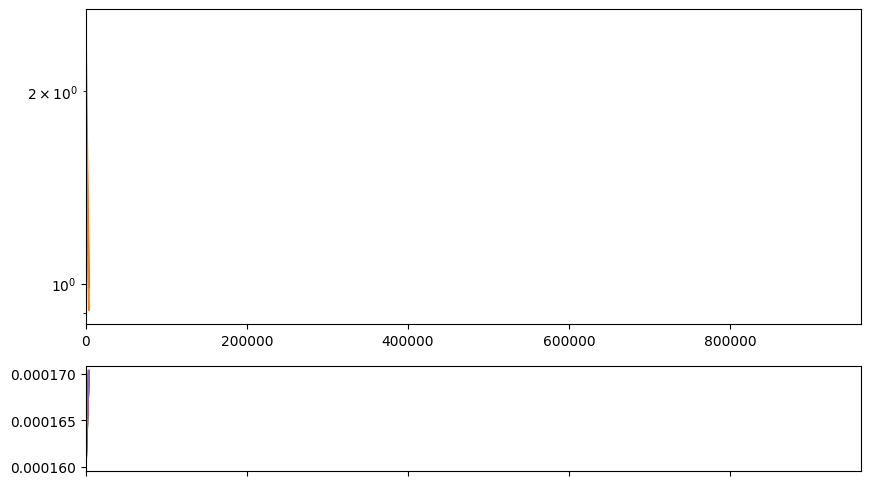

In [ ]:
# make sure it works at all
model = make_model('micro', dataset=train_ds).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=128, lr=4e-3, epochs=1,
      warmup_steps=1000, weight_decay=1e-5, clip_gradient_norm=0.1,
      table_row_every_iters=20000, run_valid_every_iters=4000)

samples,train,val,time
20000,3.00902,3.07516,00:44
40000,2.38150,2.44922,01:28
60000,2.31558,2.31341,02:12
80000,2.22452,2.24761,02:56
100000,2.13597,2.17813,03:40
120000,2.11299,2.11441,04:24
140000,2.08276,2.08359,05:08
140368,2.03694,2.08263,05:10


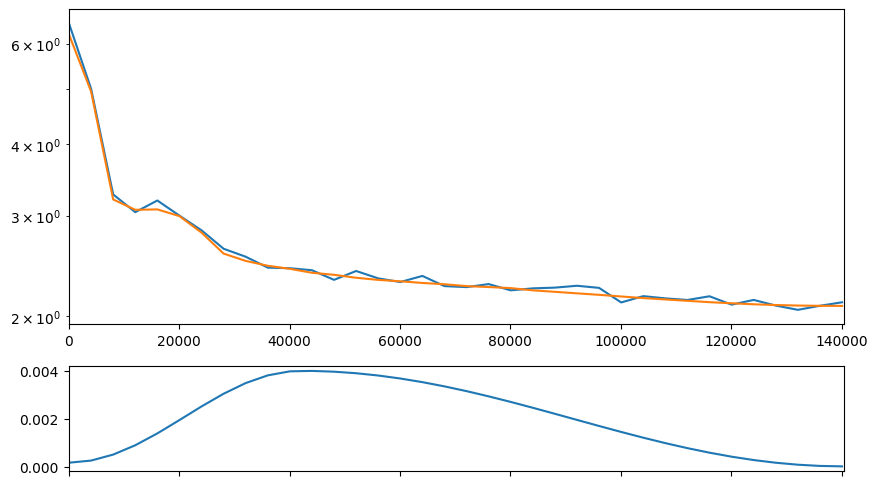

In [ ]:
# make sure it works at all
model = TSARTransformer(depth=3).cuda()
train("tsar", model, train_ds, val_ds, half=True, bs=16, lr=4e-3, epochs=1,
      table_row_every_iters=20000, run_valid_every_iters=4000)

samples,train,val,time
20000,2.87718,3.04448,00:29
40000,2.43829,2.42752,01:00
60000,2.22168,2.31068,01:29
80000,2.25326,2.25181,01:59
100000,2.16739,2.19970,02:29
120000,2.07759,2.15864,02:59
140000,2.15506,2.13614,03:30
140368,2.12502,2.13556,03:31


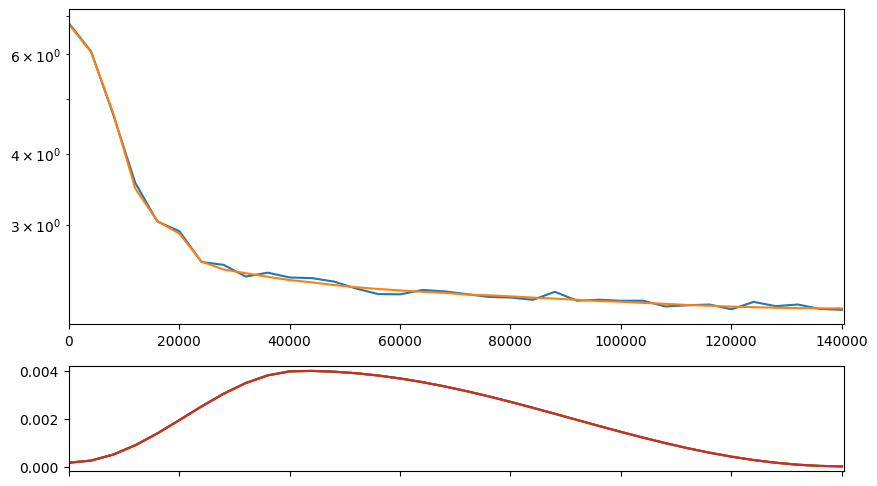

In [ ]:
# make sure it works at all
model = TSARTransformer(depth=3).cuda()
train("tsar", model, train_ds, val_ds, half=True, bs=16, lr=4e-3, epochs=1,
      table_row_every_iters=20000, run_valid_every_iters=4000)

samples,train,val,time
80000,2.56269,2.83687,22:59
160000,2.26247,2.39995,41:30
240000,2.16594,2.27455,47:38
320000,1.96548,2.00825,54:08
400000,1.86841,1.88929,1:01:07
480000,1.82314,1.85076,1:07:27
560000,1.83932,1.81487,1:13:35
640000,1.80581,1.79792,1:19:55
720000,1.74787,1.78892,1:26:10
800000,1.79779,1.78353,1:32:32


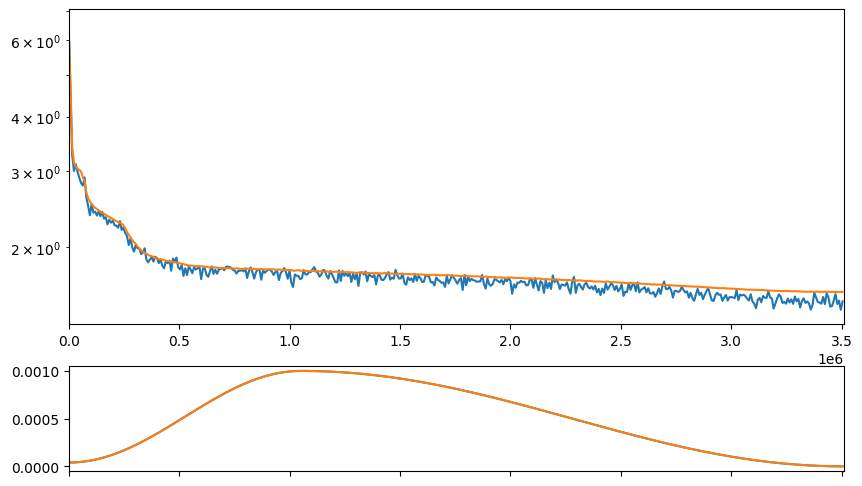

In [ ]:
model = TSARTransformer(depth=3).cuda()
train("tsar-140k", model, train_ds, val_ds, half=True, bs=8, lr=1e-3, epochs=25, warmup=0,
      table_row_every_iters=80000, run_valid_every_iters=8000)

In [ ]:
torch.save(model.state_dict(), 'tsar-140k-25e-ce1.58.pth')

samples,train,val,time
80000,2.31314,2.41210,04:53
160000,2.16040,2.25076,09:42
240000,2.09020,2.14504,14:51
320000,1.95545,2.00177,19:52
400000,1.83738,1.87890,24:42
480000,1.75185,1.82079,29:49
560000,1.72557,1.78461,34:49
640000,1.73570,1.76621,39:40
720000,1.69044,1.75392,44:40
800000,1.67324,1.73999,49:35


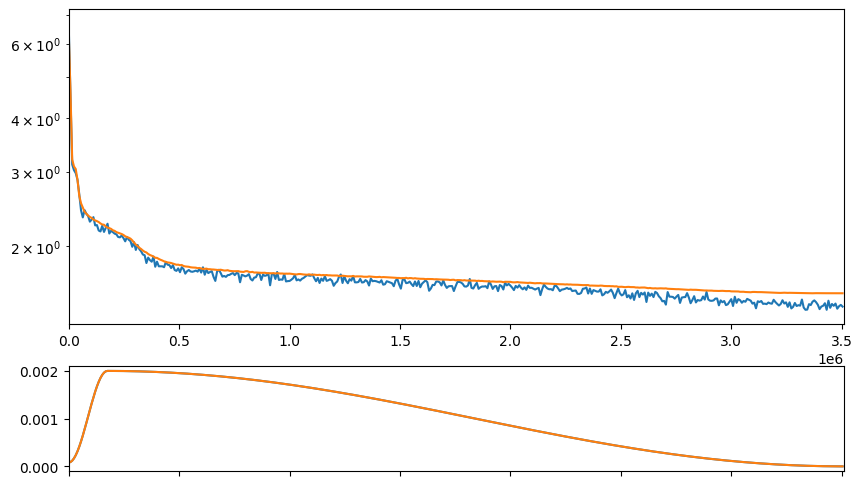

In [ ]:
# Whisper tiny sized model
model = TSARTransformer(depth=4).cuda()
train("tsar-140k-4l", model, train_ds, val_ds, half=True, bs=16, lr=2e-3, epochs=25, warmup=0, pct_start=0.05,
      table_row_every_iters=80000, run_valid_every_iters=8000, chkpt_every_iters=80000)

In [ ]:
torch.save(model.state_dict(), 'tsar-140k-4l-25e-ce1.55.pth')

# Sample from the model

In [ ]:
model = TSARTransformer(depth=4, n_head=6, stoks_len=1500, ttoks_len=250)
state_dict = {k.replace('model.', ''):v for k,v in torch.load('t2s_up-20e-ce1.15.ckpt', map_location='cpu')['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval();

In [ ]:
model.save_model('t2s_up.model')

In [ ]:
model = TSARTransformer(depth=4).cuda()
model.load_state_dict(torch.load('tsar-140k-4l-25e-ce1.55.pth')) #'/scrach/tsar-checkpoints/1480000.pt')) #  tsar-32k-60e-ce1.87.pth
model.eval().cuda();

In [ ]:
model = TSARTransformer.load_model(local_filename='t2s_up.model').cuda()

In [ ]:
whmodel = whisper.load_model('tiny.en')

In [ ]:
from whisperspeech.extract_stoks import RQBottleneckTransformer
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                              threshold_ema_dead_code=0.1)
vqmodel.load_state_dict(torch.load('./vqmodel2-tiny-1000h.pth', map_location='cpu'))
vqmodel.eval().cuda();

In [ ]:
import torch.nn.functional as F
from fastprogress import progress_bar
tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)

In [ ]:
tst_toks = tokenizer.encode()
tst_toks = F.pad(torch.tensor(tst_toks), (0, 250 - len(tst_toks)), value=tokenizer.eot).unsqueeze(0)

In [ ]:
stoks = model.generate("""We choose to train a text to speech system this year not because this is easy,
but because this is hard, because that goal will serve to organize and measure
the best of our energies and skills, because that challenge is one that we are willing
to accept, one we are unwilling to postpone, and one we intend to win! And the others too.""")

In [ ]:
vqmodel.decode_text(stoks)

[DecodingResult(audio_features=tensor([[-0.7910, -0.5942,  0.4592,  ..., -0.1428,  3.3262, -1.4307],
         [-0.9199,  1.2129, -1.3701,  ..., -0.5234,  1.3027, -3.1348],
         [-0.7476,  1.3135, -1.3564,  ..., -0.0090,  0.8394, -3.2246],
         ...,
         [-0.2534,  1.3799,  0.6147,  ...,  1.4482, -1.5518, -0.7515],
         [-0.4771,  1.6162,  0.1990,  ...,  2.2168, -1.4336, -0.7881],
         [-0.8374,  1.5225, -0.2974,  ...,  2.6660, -1.2432, -0.7119]],
        device='cuda:0', dtype=torch.float16), language='en', language_probs=None, tokens=[50363, 775, 3853, 284, 4512, 3434, 284, 4046, 1080, 428, 614, 11, 407, 780, 428, 318, 2562, 13, 50688, 50688, 6256, 84, 11, 780, 428, 318, 1327, 11, 780, 326, 3061, 481, 4691, 284, 16481, 290, 3953, 50975, 50975, 2861, 1266, 286, 674, 27598, 290, 4678, 13, 51176, 51176, 4362, 326, 6459, 530, 326, 356, 389, 4684, 374, 2509, 2845, 530, 11, 530, 356, 389, 19084, 51509, 51509], text='We choose to train attacks to speech system this year, 

In [ ]:
whmodel = whmodel.float()

In [ ]:
decode_stoks(toks)

RuntimeError: "addmm_impl_cpu_" not implemented for 'Half'

In [ ]:
torch.save(toks, 'sampled-jfk-2.pth')

In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(val_ds, batch_size=16)

NameError: name 'val_ds' is not defined

In [ ]:
bx, by = [x.cuda() for x in next(iter(dl))]

In [ ]:
bx.shape, by.shape

(torch.Size([16, 200]), torch.Size([16, 1500]))

In [ ]:
with torch.no_grad():
    logits, loss = model(bx, by)
loss

tensor(1.4946, device='cuda:0')

In [ ]:
(by[5] == 1024).sum()

tensor(141, device='cuda:0')

In [ ]:
by[5,:-141]

tensor([ 78, 980, 980,  ..., 216, 690, 216], device='cuda:0')

In [ ]:
x = vqmodel.rq.layers[0]._codebook.embed[0,by[5,:-141].to(torch.long).view(-1)]
x = F.pad(x, (0, 0, 0, 1500-len(x)))
orig_embs = vqmodel.ln_post(vqmodel.out_blocks((vqmodel.rq.layers[0].project_out(x) + vqmodel.positional_embedding).unsqueeze(0)))
whmodel.decode(orig_embs, whisper.DecodingOptions(language='en'))

[DecodingResult(audio_features=tensor([[-1.7002, -1.3105, -0.0891,  ..., -1.5332,  0.6606, -3.5156],
         [-1.5342, -0.3982,  1.1299,  ..., -1.8730, -0.1315, -4.1523],
         [-1.5029, -0.5972,  0.6626,  ..., -1.5752, -0.1542, -4.1172],
         ...,
         [-0.2218,  1.3877,  0.6792,  ...,  1.5840, -1.5488, -0.7349],
         [-0.4180,  1.5811,  0.3328,  ...,  2.4277, -1.4521, -0.7466],
         [-0.7339,  1.4521, -0.0561,  ...,  2.8633, -1.2754, -0.6807]],
        device='cuda:0', dtype=torch.float16), language='en', language_probs=None, tokens=[50363, 1002, 673, 15847, 612, 11, 262, 34692, 10846, 561, 423, 284, 1394, 2491, 736, 290, 6071, 287, 262, 3024, 50619, 50619, 4252, 393, 287, 262, 23147, 6290, 286, 262, 937, 36194, 13, 50807, 50807, 1318, 318, 645, 406, 6, 46, 293, 321, 11, 691, 257, 21151, 11, 30690, 7815, 4314, 11, 290, 612, 318, 645, 14595, 13, 51145, 51145, 1439, 262, 670, 10616, 1660, 318, 1760, 319, 262, 4314, 416, 257, 14782, 12656, 13, 51371, 51371, 843, 3360

In [ ]:
def decode_stoks(stoks):
    stoks = stoks[:-(stoks == 1024).sum()]
    x = vqmodel.rq.layers[0]._codebook.embed[0,stoks.to(torch.long).view(-1)]
    x = F.pad(x, (0, 0, 0, 1500-len(x)))
    embs = vqmodel.ln_post(vqmodel.out_blocks((vqmodel.rq.layers[0].project_out(x) + vqmodel.positional_embedding).unsqueeze(0)))
    return whmodel.decode(embs, whisper.DecodingOptions(language='en'))

In [ ]:
print(tokenizer.decode(bx[5][torch.where(bx[5] != tokenizer.eot)]))

 If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no linoleum, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drainpipe, and sometimes, if the screen gets broken over the mouth of the drainpipe, toads come hopping in, and sometimes even


In [ ]:
# decode the quantized semantic tokens (they have some errors!)
print(decode_stoks(by[5])[0].text)
torch.save(by[5], 'gt-tokens.pth')

If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no L'Oleam, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drain pipe. And sometimes if the screen gets broken over the mouth of the drain pipe, toads come


In [ ]:
from fastprogress import progress_bar
# generate output using sampling, one token at a time
T=0.7
toks = []
for i in progress_bar(range(1500)):
    p, loss = model(bx[5:6], torch.tensor([toks]).cuda(), loss=None)
    last_p = p[0,-1]
    toks.append(torch.multinomial((last_p / T).softmax(-1), 1).item())
toks = torch.tensor(toks).cuda()
# btw. this is stupidly slow since it reruns the whole sequence every time, to be optimized later

In [ ]:
# decode the semantic tokens generated by the model (they have some more errors)
print(decode_stoks(toks)[0].text)
torch.save(toks, 'gen-tokens-T0.7.pth')

If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no L'Alim, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drying pipe. And sometimes, if the screen gets broken over the mouth of the drain pipe, towards
